In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
from torchvision.utils import save_image

In [30]:
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False,transform=transforms.ToTensor())

In [3]:
train_data = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=100, 
                                           shuffle=True)
 
test_data = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=100, 
                                          shuffle=False)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512) 
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.fc3 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(128, 256) 
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.fc2 = nn.Linear(256, 512)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.fc3 = nn.Linear(512, 784)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.tanh(out)
        return out

In [6]:
D = Discriminator()
G = Generator()

In [7]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002)
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
Total_loss_list = []
G_loss_list = []
for step,(x, _) in enumerate(train_data):
    # in each step, Train D
    x = x.reshape(100,784)
    R_labels = torch.ones(100, 1)
    F_labels = torch.zeros(100, 1)
    Real_output = D(x)
    Real_loss = criterion(Real_output, R_labels)
    z = torch.randn(100, 128)
    G_output = G(z)
    Fake_output = D(G_output)
    Fake_loss = criterion(Fake_output, F_labels)
    Total_loss = Real_loss + Fake_loss
    D_opt.zero_grad()
    G_opt.zero_grad()
    Total_loss.backward()
    D_opt.step()
    #Then Train G
    z = torch.randn(100, 128)
    G_output = G(z)
    Fake_output = D(G_output)
    G_loss = criterion(Fake_output, R_labels)
    D_opt.zero_grad()
    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()
    #print('step[{}/{}],Total_loss:{:.4f},G_loss:{:.4f},Real_mean:{:.2f},Fake_mean:{:.2f}'.format(step+1, 600, Total_loss.item(), G_loss.item(), Real_output.mean(), Fake_output.mean()))
    Total_loss_list.append(Total_loss)
    G_loss_list.append(G_loss)

In [ ]:
One_round = pd.DataFrame({'index': list(range(600)), 'Discriminator_loss': Total_loss_list, 'Generator_loss':G_loss_list})
plt.plot('index', 'Discriminator_loss', data=One_round)
plt.show()
plt.plot('index', 'Generator_loss', data=One_round)
plt.show()

In [8]:
num_epochs = 50

In [9]:
def denorm(x):
    out = (x+1)/2
    return out.clamp(0, 1)

In [10]:
D_real_list = []
D_fake_list = []
G_loss_list = []
for epoch in range(num_epochs):
    D_real_in_epoch = 0
    D_fake_in_epoch = 0  
    G_loss_in_epoch = 0
    for step,(x, _) in enumerate(train_data):
        x = x.reshape(100,784)
        R_labels = torch.ones(100, 1)
        F_labels = torch.zeros(100, 1)
        Real_output = D(x)
        Real_loss = criterion(Real_output, R_labels)
        z = torch.randn(100, 128)
        G_output = G(z)
        Fake_output = D(G_output)
        Fake_loss = criterion(Fake_output, F_labels)
        Total_loss = Real_loss + Fake_loss
        D_opt.zero_grad()
        G_opt.zero_grad()
        Total_loss.backward()
        D_opt.step()
        z = torch.randn(100, 128)
        G_output = G(z)
        Fake_output = D(G_output)
        G_loss = criterion(Fake_output, R_labels)
        D_opt.zero_grad()
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
        D_real_in_epoch = D_real_in_epoch + Real_loss
        D_fake_in_epoch = D_fake_in_epoch + Fake_loss
        G_loss_in_epoch = G_loss_in_epoch + G_loss
    if (epoch % 10) == 0:
        x_sample = x[:16,:]
        Fake_sample = G_output[:16].reshape(G_output[:16].size(0), 1, 28, 28)
        save_image(denorm(Fake_sample), os.path.join('GAN_img', 'fake_images_eopch{}.png'.format(epoch)),nrow=4)
    print('Epoch[{}/{}]'.format(epoch+1,num_epochs))
    D_real_list.append(D_real_in_epoch/600)
    D_fake_list.append(D_fake_in_epoch/600)
    G_loss_list.append(G_loss_in_epoch/600)

Epoch[1/50]
Epoch[2/50]
Epoch[3/50]
Epoch[4/50]
Epoch[5/50]
Epoch[6/50]
Epoch[7/50]
Epoch[8/50]
Epoch[9/50]
Epoch[10/50]
Epoch[11/50]
Epoch[12/50]
Epoch[13/50]
Epoch[14/50]
Epoch[15/50]
Epoch[16/50]
Epoch[17/50]
Epoch[18/50]
Epoch[19/50]
Epoch[20/50]
Epoch[21/50]
Epoch[22/50]
Epoch[23/50]
Epoch[24/50]
Epoch[25/50]
Epoch[26/50]
Epoch[27/50]
Epoch[28/50]
Epoch[29/50]
Epoch[30/50]
Epoch[31/50]
Epoch[32/50]
Epoch[33/50]
Epoch[34/50]
Epoch[35/50]
Epoch[36/50]
Epoch[37/50]
Epoch[38/50]
Epoch[39/50]
Epoch[40/50]
Epoch[41/50]
Epoch[42/50]
Epoch[43/50]
Epoch[44/50]
Epoch[45/50]
Epoch[46/50]
Epoch[47/50]
Epoch[48/50]
Epoch[49/50]
Epoch[50/50]


In [11]:
x_sample = x[:16,:]
Fake_sample = G_output[:16].reshape(G_output[:16].size(0), 1, 28, 28)
save_image(denorm(Fake_sample), os.path.join('GAN_img', 'fake_images_eopch{}.png'.format(50)),nrow=4)

In [16]:
torch.save(G.state_dict(), 'hw5_gan_gen.pth')
torch.save(D.state_dict(), 'hw5_gan_dis.pth')

In [12]:
D_real_list = [i.item() for i in D_real_list]  

In [13]:
D_fake_list = [i.item() for i in D_fake_list]  
G_loss_list = [i.item() for i in G_loss_list]  

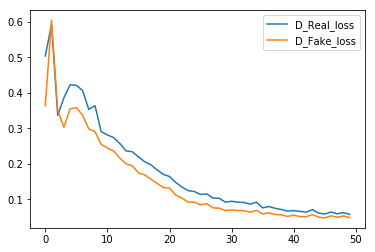

In [14]:
loss_plt = pd.DataFrame({'index': list(range(num_epochs)), 'D_Real_loss': D_real_list, 'D_Fake_loss':D_fake_list, 'G_loss':G_loss_list})
plt.plot('index', 'D_Real_loss', data=loss_plt)
plt.plot('index', 'D_Fake_loss', data=loss_plt)
plt.legend()
plt.show()

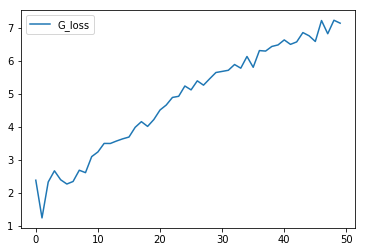

In [15]:
plt.plot('index', 'G_loss', data=loss_plt)
plt.legend()
plt.show()